In [94]:
import csv

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats.mstats import pearsonr

from gpmap.src.inference import VCregression
from gpmap.src.seq import guess_space_configuration, get_seqs_from_alleles

In [95]:
fpath = 'Rotrattanadumrong_2022_ligase_ribz_evolution/Filtered_reads_files/Filtered_LibWT_Mut_R1_R2_QS20_tolerance_1.csv'
data = pd.read_csv(fpath, usecols=['Sequences', 'RA_1', 'RA_2'], index_col=0)
data['m'], data['logm'], data['var'], data['logvar'] = data.mean(1), np.log(data).mean(1), data.var(1)*2 + 0.05, np.log(data).var(1)
data.head()

,RA_1,RA_2,m,logm,var,logvar
Sequences,,,,,,
TATCACTGGTTGTTGGACGCTTTGGATGGGTTGAA,0.460551,0.663284,0.561918,-0.592941,0.091101,0.066532
TATCACAGGTTGTAAACCATTTTGGATGGGTTGAA,0.280813,0.447017,0.363915,-1.037613,0.077624,0.108070
TATCACATGGTGTTGGACGTTTTGGATGGGTCGAA,0.061078,0.072578,0.066828,-2.709347,0.050132,0.014879
TATCACTTGTCTTAGGAGACAATGGATGGGTCGAA,0.531630,0.546976,0.539303,-0.617580,0.050235,0.000405
TATCACATGGTTTTAGACGTTATGGATGGGTCGAA,0.206064,0.242848,0.224456,-1.497445,0.051353,0.013489


/home/martigo/miniconda3/envs/gpmap/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


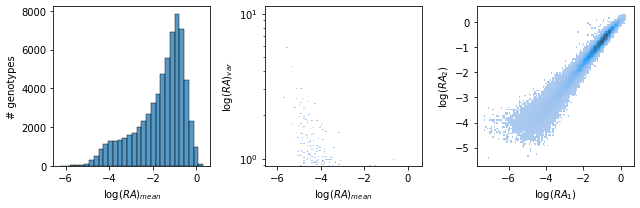

In [96]:
fig, subplots = plt.subplots(1, 3, figsize=(9, 3))

axes = subplots[0]
sns.histplot(x=data['logm'].values, ax=axes, bins=30)
axes.set(xlabel=r'$\log(RA)_{mean}$', ylabel=r'# genotypes')

axes = subplots[1]
sns.histplot(x=data['logm'].values,
             y=data['logvar'].values, ax=axes)
axes.set(xlabel=r'$\log(RA)_{mean}$', ylabel=r'$\log(RA)_{var}$', yscale='log')

axes = subplots[2]
sns.histplot(x=np.log(data['RA_1'].values),
             y=np.log(data['RA_2'].values), ax=axes)
axes.set(xlabel=r'$\log(RA_{1})$', ylabel=r'$\log(RA_{2})$')
fig.tight_layout()

In [97]:
config = guess_space_configuration(data.index)
a = [x > 1 for x in config['n_alleles']]
alleles = config['alphabet']
data['seq'] = [''.join([x for x, y in zip(seq, a) if y]) for seq in data.index]
binary_alleles = 'AB'
data['binary'] = [''.join([binary_alleles[z.index(x)] for x, y, z in zip(seq, a, alleles) if y]) for seq in data.index]
data.sort_values('seq', inplace=True)
data.head()

,RA_1,RA_2,m,logm,var,logvar,seq,binary
Sequences,,,,,,,,
TATCACAGCGCGTAAAACACAATGGATGGGTCGAA,0.296563,0.312593,0.304578,-1.189173,0.050257,0.001386,AGCGCGAAAACACAAC,BABBBABBBAABABBB
TATCACAGCGCGTAAAACACAATGGATGGGTTGAA,0.317296,0.371002,0.344149,-1.069733,0.052884,0.012226,AGCGCGAAAACACAAT,BABBBABBBAABABBA
TATCACAGCGCGTAAAACACATTGGATGGGTCGAA,0.280970,0.270548,0.275759,-1.288407,0.050109,0.000714,AGCGCGAAAACACATC,BABBBABBBAABABAB
TATCACAGCGCGTAAAACACATTGGATGGGTTGAA,0.319805,0.397730,0.358768,-1.031013,0.056072,0.023776,AGCGCGAAAACACATT,BABBBABBBAABABAA
TATCACAGCGCGTAAAACACTATGGATGGGTCGAA,0.506120,0.559888,0.533004,-0.630500,0.052891,0.005097,AGCGCGAAAACACTAC,BABBBABBBAABAABB


In [98]:
np.random.seed(3)
ntest = 5000
seqs = data.index.values
np.random.shuffle(seqs)
train, test = data.loc[seqs[:-ntest], :], data.loc[seqs[-ntest:], :]
train.shape, test.shape

((60536, 8), (5000, 8))

In [99]:
def plot_lambdas(vc):
    k = np.arange(1, vc.lambdas.shape[0])
    fig, axes = plt.subplots(1, 1, figsize=(4, 3))
    axes.plot(k, vc.lambdas[1:], c='purple', lw=1)
    axes.scatter(k, vc.lambdas[1:], c='purple')
    axes.set(xlabel=r'Interaction order $k$', ylabel=r'$\lambda_k$',
             yscale='log', xticks=k)

In [100]:
vc = VCregression()
vc.fit(train['binary'].values, y=train['m'].values,
       variance=train['var'].values, cross_validation=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.55s/it]


array([5.92619873e+03, 4.50015601e+01, 7.55879526e+00, 1.27055030e+00,
       2.13813811e-01, 3.59996434e-02, 6.06226948e-03, 1.02086854e-03,
       1.71903686e-04, 2.89318084e-05, 4.86815174e-06, 8.19384182e-07,
       1.37966047e-07, 2.32245625e-08, 3.91438497e-09, 6.60069680e-10,
       1.11274936e-10])

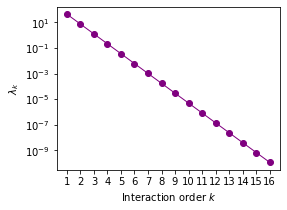

In [101]:
plot_lambdas(vc)

In [85]:
# Remove very high order components
#vc.lambdas[np.argmin(vc.lambdas):] = np.min(vc.lambdas)
#plot_lambdas(vc)

In [102]:
pred = vc.predict()
pred_data = data.join(pred, on='binary')
pred_data.head()

,RA_1,RA_2,m,logm,var,logvar,seq,binary,ypred
Sequences,,,,,,,,,
TATCACTTCTTTTAGACGGTATTGGATGGGTCGAA,0.296563,0.312593,0.304578,-1.189173,0.050257,0.001386,AGCGCGAAAACACAAC,BABBBABBBAABABBB,0.321429
TATCACATGGTGTTAGACACAATGGATGGGTTGAA,0.317296,0.371002,0.344149,-1.069733,0.052884,0.012226,AGCGCGAAAACACAAT,BABBBABBBAABABBA,0.341551
TATCACTGGGTGTAGAAGATTATGGATGGGTCGAA,0.280970,0.270548,0.275759,-1.288407,0.050109,0.000714,AGCGCGAAAACACATC,BABBBABBBAABABAB,0.306648
TATCACTTGGCTTTAAAGGCAATGGATGGGTTGAA,0.319805,0.397730,0.358768,-1.031013,0.056072,0.023776,AGCGCGAAAACACATT,BABBBABBBAABABAA,0.327286
TATCACTTCGCTTTAACCATATTGGATGGGTCGAA,0.506120,0.559888,0.533004,-0.630500,0.052891,0.005097,AGCGCGAAAACACTAC,BABBBABBBAABAABB,0.440704


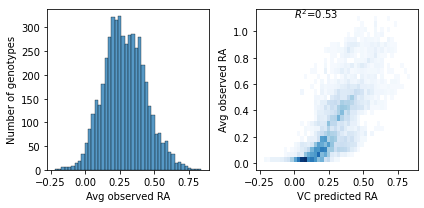

In [103]:
predtest = pred_data.loc[test.index.values, :]

fig, subplots = plt.subplots(1, 2, figsize=(6, 3))

axes = subplots[0]
sns.histplot(x=predtest['ypred'].values, ax=axes)
axes.set(xlabel='Avg pred RA', ylabel='Number of genotypes')


axes = subplots[1]
sns.histplot(x=predtest['ypred'].values, y=predtest['m'].values, cmap='Blues') # , log_scale=True
axes.set(xlabel='VC predicted RA', ylabel='Avg observed RA')

r2 = pearsonr(predtest['ypred'].values, predtest['m'].values)[0] ** 2
axes.text(0.0005, 1.1, r'$R^2$=' + '{:.2f}'.format(r2))
fig.tight_layout()

In [40]:
pred.columns = ['RA']
pred.to_csv('RA.vc.csv', quoting=csv.QUOTE_NONNUMERIC)

In [104]:
pred_data.set_index('seq')[['ypred']].to_csv('RA.pred.csv')
pred_data.set_index('binary')[['m', 'var']].to_csv('RA.data.csv', )

In [94]:
pred_data.head()

,RA_1,RA_2,m,var,seq,binary,ypred
Sequences,,,,,,,
TATCACAGCGCGTAAAACACAATGGATGGGTCGAA,0.296563,0.312593,0.304578,0.000128,AGCGCGAAAACACAAC,0000000000000000,0.226319
TATCACAGCGCGTAAAACACAATGGATGGGTTGAA,0.317296,0.371002,0.344149,0.001442,AGCGCGAAAACACAAT,0000000000000001,0.234680
TATCACAGCGCGTAAAACACATTGGATGGGTCGAA,0.280970,0.270548,0.275759,0.000054,AGCGCGAAAACACATC,0000000000000010,0.205863
TATCACAGCGCGTAAAACACATTGGATGGGTTGAA,0.319805,0.397730,0.358768,0.003036,AGCGCGAAAACACATT,0000000000000011,0.216155
TATCACAGCGCGTAAAACACTATGGATGGGTCGAA,0.506120,0.559888,0.533004,0.001445,AGCGCGAAAACACTAC,0000000000000100,0.347327


In [24]:
pred_data.to_csv('data.full.csv', quoting=csv.QUOTE_NONNUMERIC)

/home/martigo/miniconda3/envs/gpmap/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/martigo/miniconda3/envs/gpmap/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


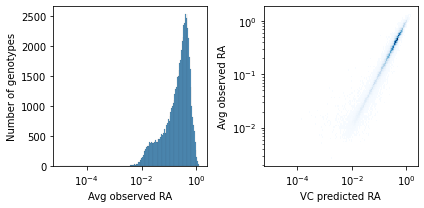

In [43]:
fig, subplots = plt.subplots(1, 2, figsize=(6, 3))

axes = subplots[0]
sns.histplot(x=pred_data['ypred'].values, ax=axes, log_scale=True)
axes.set(xlabel='Avg observed RA', ylabel='Number of genotypes')


axes = subplots[1]
sns.histplot(x=pred_data['ypred'].values, y=pred_data['m'].values, cmap='Blues', log_scale=True)
axes.set(xlabel='VC predicted RA', ylabel='Avg observed RA')

fig.tight_layout()